In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

import datetime
import math

%matplotlib inline
%reload_ext tensorboard

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

def create_split(df, pct_train, pct_val, batch_size, window_size):
    length = df.shape[0]
    temp_train_size = find_batch_gcd(math.floor(pct_train * length), batch_size)
    test_size = length - temp_train_size
    train_size = find_batch_gcd(math.floor((1 - pct_val) * temp_train_size), batch_size)
    val_size = temp_train_size - train_size
    df_train = df[:- val_size - test_size]
    df_val = df[- val_size - test_size - window_size:- test_size]
    df_test = df[- test_size - window_size:]
    return df_train, df_val, df_test

def find_batch_gcd(length, batch_size):
    while length % batch_size != 0:
        length -= 1
    return length

def create_dataset(df, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        v = df.iloc[i:(i + window_size)].values
        X.append(v)
        y.append(df["Close"].iloc[i + window_size])
    return np.array(X), np.array(y)

def create_multi_pred_dataset(df, window_size, time_steps):
    X, y = [], []
    for i in range(len(df) - window_size - time_steps - 1):
        v = df.iloc[i:(i + window_size)].values
        X.append(v)
        y.append(df["Close"].iloc[i + window_size:i + window_size + time_steps].values)
    return np.array(X), np.array(y)

def create_model(nodes, optimizer, dropout, X_train):
    model = Sequential()
    model.add(LSTM(nodes[0], input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(LSTM(nodes[1], return_sequences=True))
    model.add(LSTM(nodes[2]))
    model.add(Dropout(dropout))
    model.add(Dense(nodes[3]))
    model.compile(loss="mse", optimizer=optimizer, metrics=['mae'])
    return model

def train_model(pair, batch_size, window_size, nodes_arr, optimizer, dropout, epochs):
    series = pd.read_csv("../data/processed/{}_processed.csv".format(pair))

    buy = pair[:3]
    sell = pair[3:]

    series = series[series.shape[0] % batch_size:]
    close = series[['Real Close']]

    series = series.drop(['Time', 'Real Close'], axis=1)
    series = series[['Close', 'EMA_10', 'EMA_50', 'RSI', 'A/D Index',
                     #'{} Interest Rate'.format(buy), '{} Interest Rate'.format(sell), '{}_CPI'.format(buy), '{}_CPI'.format(sell),
                     '{} Twitter Sentiment'.format(buy), '{} Twitter Sentiment'.format(sell),
                     #'{} News Sentiment'.format(buy), '{} News Sentiment'.format(sell),
                     #'EUR_GDP', 'USD_GDP', 'EUR_PPI', 'USD_PPI', 'USD Unemployment Rate', 'EUR Unemployment Rate'
                    ]]

    df_train, df_val, df_test = create_split(series, 0.75, 0.1, batch_size, window_size)
    print(f'df_train.shape {df_train.shape}, df_validation.shape {df_val.shape}, df_test.shape {df_test.shape}')
    
    closeScaler = MinMaxScaler(feature_range=(0, 1))
    featureScaler = MinMaxScaler(feature_range=(0, 1))
    df_train = df_train.copy()
    df_val = df_val.copy()
    df_train.loc[:, ['Close']] = closeScaler.fit_transform(df_train[['Close']])
    df_train.loc[:, ~df_train.columns.isin(['Close'])] = featureScaler.fit_transform(df_train.loc[:, ~df_train.columns.isin(['Close'])])
    df_val.loc[:, ['Close']] = closeScaler.transform(df_val[['Close']])
    df_val.loc[:, ~df_val.columns.isin(['Close'])] = featureScaler.transform(df_val.loc[:, ~df_val.columns.isin(['Close'])])

    X_train, y_train = create_multi_pred_dataset(df_train, window_size, nodes_arr[3])
    X_val, y_val = create_multi_pred_dataset(df_val, window_size, nodes_arr[3])

    model = create_model(nodes_arr, optimizer, dropout, X_train)

    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    log_dir = "logs/tuning/" + current_time
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, update_freq='epoch', profile_batch=0, histogram_freq=1)

    history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=False,
                    callbacks=[tensorboard_callback]
                   )
    model.save("../models/{}".format(pair))
    joblib.dump(featureScaler, "../scalers/{}/features.bin".format(pair))
    joblib.dump(closeScaler, "../scalers/{}/close.bin".format(pair))
    
    del model
    
    return history

def visualize_loss(history):
    fig = plt.figure(figsize=(16, 10))
    ax1 = fig.subplots(1)
    ax1.set_title('Model Loss')
    ax1.set(xlabel='Epoch', ylabel='Loss')
    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Val Loss')
    ax1.legend()

In [3]:
batch_size = 64
window_size = 600
nodes = [80, 64, 32, 3]
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
dropout = 0.2
epochs = 15
history = train_model("EURUSD", batch_size, window_size, nodes, optimizer, dropout, epochs)

df_train.shape (50368, 13), df_validation.shape (5832, 13), df_test.shape (18888, 13)
Epoch 1/15
784/784 [==============================] - 271s 346ms/step - loss: 0.0113 - mae: 0.0777 - val_loss: 0.0047 - val_mae: 0.0492
Epoch 2/15
784/784 [==============================] - 267s 341ms/step - loss: 0.0045 - mae: 0.0529 - val_loss: 0.0033 - val_mae: 0.0378
Epoch 3/15
784/784 [==============================] - 281s 358ms/step - loss: 0.0029 - mae: 0.0421 - val_loss: 0.0035 - val_mae: 0.0395
Epoch 4/15
784/784 [==============================] - 277s 353ms/step - loss: 0.0020 - mae: 0.0343 - val_loss: 0.0032 - val_mae: 0.0385
Epoch 5/15
784/784 [==============================] - 273s 349ms/step - loss: 0.0014 - mae: 0.0282 - val_loss: 0.0025 - val_mae: 0.0318
Epoch 6/15
784/784 [==============================] - 275s 351ms/step - loss: 0.0011 - mae: 0.0239 - val_loss: 0.0020 - val_mae: 0.0274
Epoch 7/15
784/784 [==============================] - 275s 351ms/step - loss: 8.5971e-04 - mae: 0.

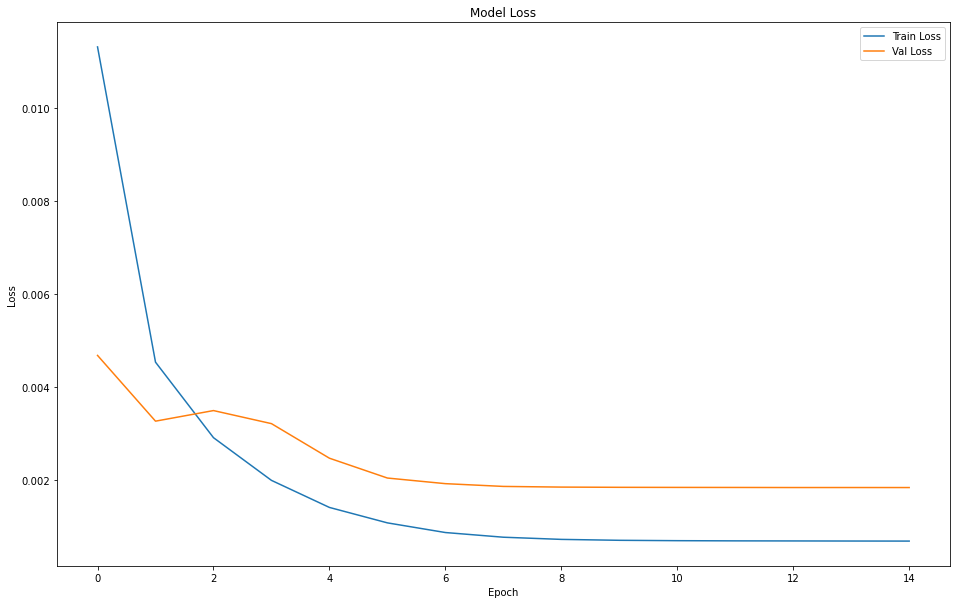

In [4]:
visualize_loss(history)

In [5]:
tensorboard --logdir logs/training

Reusing TensorBoard on port 6006 (pid 9988), started 1 day, 3:57:44 ago. (Use '!kill 9988' to kill it.)